In [1]:
import os

os.environ['HDF5_DISABLE_VERSION_CHECK'] = "1"

import datetime as dt 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr

from sklearn import metrics

from eofs.xarray import Eof
from esem import rf_model

from utils import *

2024-01-28 21:03:03.453972: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-28 21:03:03.454010: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# path to save the netcdf file
path_output ='outputs_ssp245_prediction_ESEm.nc'


In [3]:
train_files = [ "historical", "ssp585", "ssp126", "ssp370", ]
# Create training and testing arrays
X, solvers = create_predictor_data(train_files)
Y = create_predictdand_data(train_files)



In [4]:

rf_tas = rf_model(X, Y['tas'], random_state=0, bootstrap=True, max_features='sqrt', **{'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 7,  'max_depth': 5,})
rf_pr = rf_model(X, Y['pr'], random_state=0, bootstrap=True, max_features='sqrt', **{'n_estimators': 150, 'min_samples_split': 15, 'min_samples_leaf': 8,'max_depth': 40,})
rf_pr90 = rf_model(X, Y['pr90'], random_state=0, bootstrap=True, max_features='sqrt',**{'n_estimators': 250, 'min_samples_split': 15, 'min_samples_leaf': 12,'max_depth': 25,})
rf_dtr = rf_model(X, Y["diurnal_temperature_range"], random_state=0, bootstrap=True, max_features='sqrt',**{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_depth': 20,})
# rf_tas = rf_model(X, Y['tas'], random_state=0, bootstrap=True, max_features='auto', **{'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 7,  'max_depth': 5,})
# rf_pr = rf_model(X, Y['pr'], random_state=0, bootstrap=True, max_features='auto', **{'n_estimators': 150, 'min_samples_split': 15, 'min_samples_leaf': 8,'max_depth': 40,})
# rf_pr90 = rf_model(X, Y['pr90'], random_state=0, bootstrap=True, max_features='auto',**{'n_estimators': 250, 'min_samples_split': 15, 'min_samples_leaf': 12,'max_depth': 25,})
# rf_dtr = rf_model(X, Y["diurnal_temperature_range"], random_state=0, bootstrap=True, max_features='auto',**{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_depth': 20,})

rf_tas.train()
rf_pr.train()
rf_pr90.train()
rf_dtr.train()


2024-01-28 21:03:11.084383: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-28 21:03:11.084509: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-01-28 21:03:11.084598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-01-28 21:03:11.116002: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2024-01-28 21:03:11.116111: W tensorflow/stream_executor/platform/default/dso_loader

In [5]:
## Test on SSP245

X_test = get_test_data('ssp245', solvers)
Y_test = create_predictdand_data(['ssp245'])

tas_truth = Y_test["tas"]
pr_truth = Y_test["pr"]
pr90_truth = Y_test["pr90"]
dtr_truth = Y_test["diurnal_temperature_range"]


In [6]:
m_out_tas, _ = rf_tas.predict(X_test)
m_out_pr, _ = rf_pr.predict(X_test)
m_out_pr90, _ = rf_pr90.predict(X_test)
m_out_dtr, _ = rf_dtr.predict(X_test)


In [7]:

xr_output = xr.Dataset(dict(tas=m_out_tas, pr=m_out_pr, pr90=m_out_pr90, diurnal_temperature_range=m_out_dtr)).assign_coords(time=m_out_tas.sample + 2014)
#save output to netcdf 
xr_output.to_netcdf(path_output,'w')

In [8]:
print(f"RMSE: {get_rmse(tas_truth[35:], m_out_tas[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(dtr_truth[35:], m_out_dtr[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(pr_truth[35:], m_out_pr[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(pr90_truth[35:], m_out_pr90[35:]).mean()}")

RMSE: 0.6823172244093356


RMSE: 0.16537489851670092


RMSE: 0.5578336782743653


RMSE: 1.5880423328622344


In [9]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, check_scoring, mean_squared_error

def get_rmse_array(truth, pred):
    print(truth.shape, pred.shape)
    weights = np.cos(np.deg2rad(truth.lat))

    return np.sqrt(((truth - pred.reshape(-1, 96,144))**2).weighted(weights).mean(['lat', 'lon'])).data.mean()


In [10]:
%%time
pr_result = permutation_importance(
    rf_pr.model.model, X_test[35:], pr_truth.sel(time=slice(2050,None)), n_repeats=10, random_state=42, n_jobs=1, scoring=make_scorer(get_rmse_array))


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
CPU times: user 30.7 s, sys: 51.8 ms, total: 30.8 s
Wall time: 30.6 s


In [11]:
importances = rf_pr.model.model.feature_importances_

In [12]:
feature_names = list(X.columns)

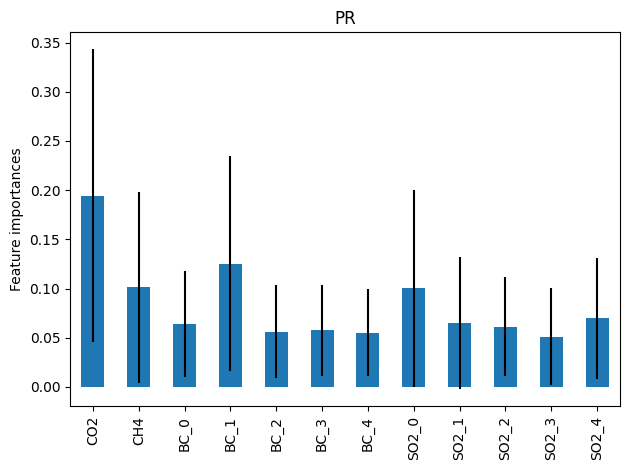

In [13]:
std = np.std([tree.feature_importances_ for tree in rf_pr.model.model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("PR")
ax.set_ylabel("Feature importances")
fig.tight_layout()